In [1]:
import pathlib
import sys

import xarray
import zarr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import cycler
from scipy.interpolate import interp1d

import astropy.units as u
from astropy.visualization import LogStretch, ImageNormalize, quantity_support, time_support
import astropy.table
import astropy.time
import astropy.wcs
from astropy.coordinates import SkyCoord
import asdf

import sunpy.map
import ndcube
import fiasco
from demcmc import EmissionLine, TempBins, ContFuncDiscrete, plot_emission_loci, predict_dem_emcee
import eispac.core
from aiapy.calibrate import estimate_error
from xrtpy.response import TemperatureResponseFundamental
from synthesizAR.instruments.sdo import _TEMPERATURE_RESPONSE as AIA_TEMPERATURE_RESPONSE

sys.path.append('../pipeline')
from loop_selection import interpolate_hpc_coord, straight_loop_indices
from density_diagnostic import get_line_ratio

In [2]:
ac1 = cycler.cycler(color=["#0A9F9D", "#CEB175", "#E54E21", "#6C8645", "#C18748"])
ac2 = cycler.cycler(color=["#C52E19", "#AC9765", "#54D8B1", "#b67c3b", "#175149", "#AF4E24"])
ac3 = cycler.cycler(color=["#FBA72A", "#D3D4D8", "#CB7A5C", "#5785C1"])
ac3_alt = cycler.cycler(color=["#5785C1", "#FBA72A",  "#CB7A5C", "#D3D4D8", ])
darjeeling = cycler.cycler(color=["#FF0000", "#00A08A", "#F2AD00", "#F98400", "#5BBCD6"])

# Figures

In this notebook, layout all of the figures we need for each panel of the poster

In [3]:
data_root = pathlib.Path('../pipeline/data/')
figure_directory = pathlib.Path('../src/figures/')

In [4]:
eis_loop = xarray.open_dataset(data_root / 'EIS' / 'loop_cutouts_no_background.nc')

In [5]:
aia_loop = xarray.open_dataset(data_root / 'AIA' / 'loop_cutouts_no_background.nc')

In [6]:
xrt_loop = xarray.open_dataset(data_root / 'XRT'/ 'loop_cutouts_no_background.nc')

In [7]:
with asdf.open('../pipeline/static/traced-loop.asdf') as af:
    traced_loop = af.tree['loop']
traced_loop[:4]
traced_loop_interp = interpolate_hpc_coord(traced_loop, 25)
loop_width = 45 * u.arcsec

## AR Maps

In [8]:
m_eis_intensity = sunpy.map.Map(data_root / 'EIS' / 'level_2.5' / 'eis_20120924_105026.fe_12_195_119.2c-0.int.fits')
m_eis_intensity = m_eis_intensity._new_instance(m_eis_intensity.data, m_eis_intensity.meta, mask=m_eis_intensity.data==0.0)
m_eis_velocity = sunpy.map.Map(data_root / 'EIS' / 'level_2.5' / 'eis_20120924_105026.fe_12_195_119.2c-0.vel.fits')

In [9]:
m_xrt = sunpy.map.Map(data_root / 'XRT' / 'level_2.5' / 'comp_XRT20120924_100307.8.fits')

In [10]:
root = zarr.open(data_root / 'AIA' / 'level_2')
t_start = astropy.time.Time('2012-09-24 09:00:00')
aia_channel = '171'
cube_aia = ndcube.NDCube(root[aia_channel][:],
                         wcs=astropy.wcs.WCS(root[aia_channel].attrs['wcs']),
                         unit=root[aia_channel].attrs['meta']['bunit'],
                         meta=root[aia_channel].attrs['meta'],)
time_aia = cube_aia.axis_world_coords(0)[0] - cube_aia.axis_world_coords(0)[0][0] + t_start
index_eis = np.argmin(np.fabs((time_aia - m_eis_intensity.date_average).to_value('s')))
m_aia_171 = sunpy.map.Map(cube_aia[index_eis,...].data, cube_aia.meta)
aia_channel = '193'
cube_aia = ndcube.NDCube(root[aia_channel][:],
                         wcs=astropy.wcs.WCS(root[aia_channel].attrs['wcs']),
                         unit=root[aia_channel].attrs['meta']['bunit'],
                         meta=root[aia_channel].attrs['meta'],)
m_aia_193 = sunpy.map.Map(cube_aia[index_eis,...].data, cube_aia.meta)

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 180 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 180 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


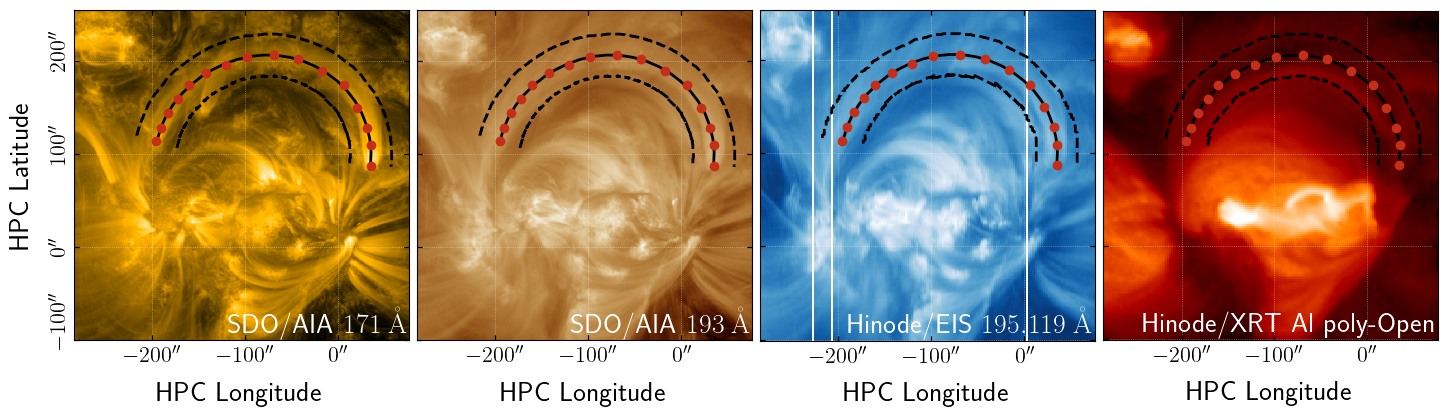

In [11]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array([1,3/8]))
for i,m in enumerate([m_aia_171, m_aia_193, m_eis_intensity, m_xrt,]):
    m = m.submap(SkyCoord(Tx=m.bottom_left_coord.Tx, Ty=-100*u.arcsec, frame=m.coordinate_frame),
                 top_right=m.top_right_coord)
    ax = fig.add_subplot(1,4,i+1,projection=m)
    m.plot(axes=ax, title=False, annotate=False)
    ax.plot_coord(traced_loop_interp, color='k')
    ax.plot_coord(traced_loop, ls='', marker='o', color=list(ac2)[0]['color'])
    _, _, indices = straight_loop_indices(traced_loop_interp, loop_width, m.wcs)
    inner_coord = m.wcs.pixel_to_world(*indices[:,0,:].T)
    outer_coord = m.wcs.pixel_to_world(*indices[:,-1,:].T)
    ax.plot_coord(inner_coord, color='k', ls='--')
    ax.plot_coord(outer_coord, color='k', ls='--')
    filter_label = m.wavelength.to_string(format="latex_inline") if m.wavelength is not None else m.measurement 
    ax.text(m.top_right_coord.Tx.to_value('deg'),
            m.bottom_left_coord.Ty.to_value('deg'),
            f'{m.observatory}/{m.instrument} {filter_label}',
            color='w',
            verticalalignment='bottom',
            horizontalalignment='right',
            fontsize=plt.rcParams['axes.labelsize'],
            transform=ax.get_transform('world'))
    if i==0:
        ax.coords[1].set_axislabel('HPC Latitude')
        ax.coords[1].set_ticklabel(rotation=90)
    else:
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_axislabel('HPC Longitude')

plt.subplots_adjust(wspace=0.025, hspace=0.025, left=0.04167, right=1-0.04167, bottom=0, top=1)
fig.savefig(figure_directory / 'ar_maps.pgf',)

## Loop Plots

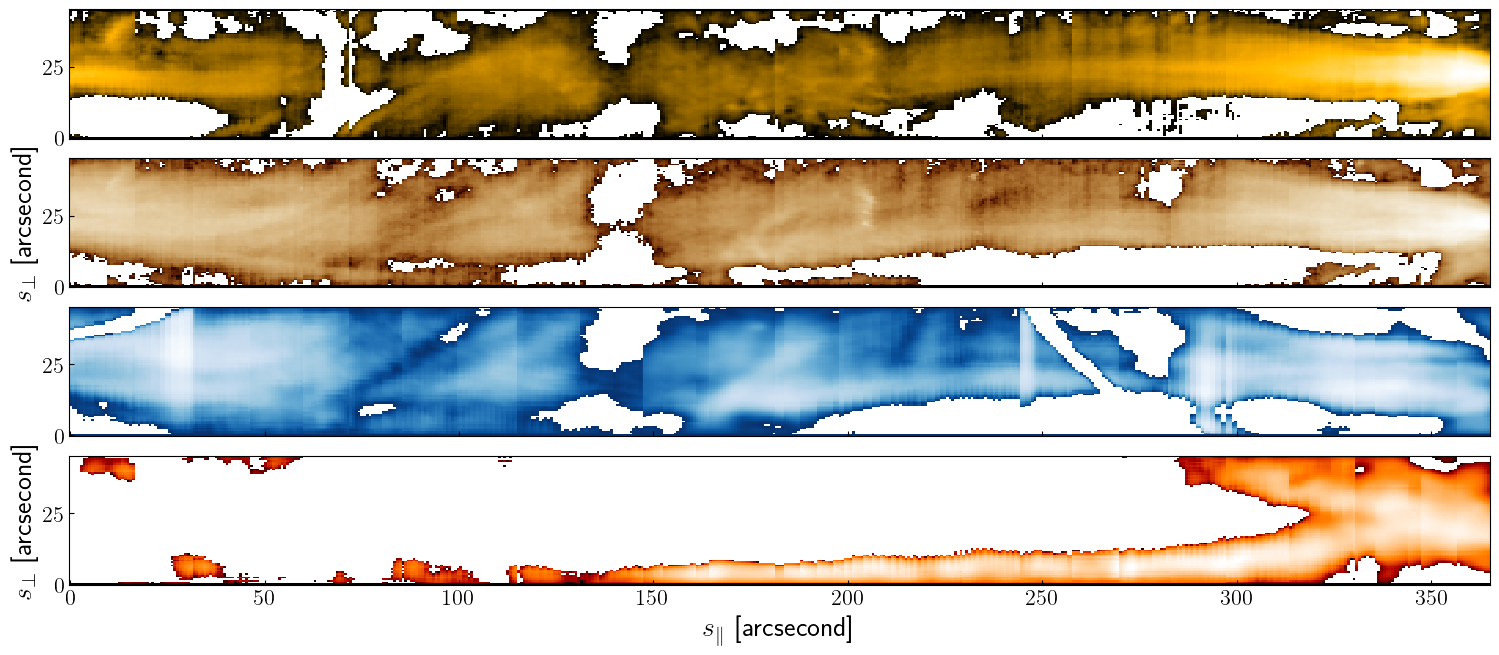

In [12]:
aspect = 0.175
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array((1, aspect*4)),
                 layout='constrained')
ax = fig.add_subplot(4,1,1)
aia_loop['171'][index_eis].plot.imshow(ax=ax,x='s_parallel',y='s_perp', cmap=m_aia_171.plot_settings['cmap'], norm=m_aia_171.plot_settings['norm'], add_colorbar=False)
ax.set_title('')
ax.set_xlabel('')
ax.axes.get_xaxis().set_ticklabels([])
ax.set_ylabel('')
ax = fig.add_subplot(4,1,2)
aia_loop['193'][index_eis].plot.imshow(ax=ax,x='s_parallel',y='s_perp', cmap=m_aia_193.plot_settings['cmap'], norm=m_aia_193.plot_settings['norm'], add_colorbar=False,)
ax.set_title('')
ax.set_xlabel('')
ax.axes.get_xaxis().set_ticklabels([])
ax.set_ylabel(r'$s_\perp$ [arcsecond]')
ax = fig.add_subplot(4,1,3)
eis_loop['Fe XII 195.119_intensity'].plot.imshow(ax=ax, x='s_parallel', y='s_perp', cmap=m_eis_intensity.plot_settings['cmap'], norm=m_eis_intensity.plot_settings['norm'], add_colorbar=False)
ax.set_xlabel('')
ax.axes.get_xaxis().set_ticklabels([])
ax.set_ylabel(r'')
ax = fig.add_subplot(4,1,4)
xrt_loop['Al poly-Open'].plot.imshow(ax=ax, x='s_parallel', y='s_perp', cmap=m_xrt.plot_settings['cmap'], norm=m_xrt.plot_settings['norm'], add_colorbar=False)
ax.set_xlabel(r'$s_\parallel$ [arcsecond]')
ax.set_ylabel(r'$s_\perp$ [arcsecond]')
fig.savefig(figure_directory / 'straightened_loops.pgf',)

## Density Diagnostic

In [13]:
density_for_diagnostic = np.logspace(7,12,40) * u.Unit('cm-3')
temperature = np.linspace(1,2,1000)*u.MK
fe12 = fiasco.Ion('Fe XII', temperature)
fe13 = fiasco.Ion('Fe XIII', temperature)

In [14]:
intensity_ratio_fe12 = get_line_ratio(fe12, density_for_diagnostic, [186.854, 186.887] * u.angstrom, [195.119] * u.angstrom)
intensity_ratio_fe13 = get_line_ratio(fe13, density_for_diagnostic, [203.795, 203.826] * u.angstrom, [202.044] * u.angstrom)

In [15]:
observed_density = xarray.open_dataset(data_root / 'diagnostics' / 'line_ratio_density.nc')

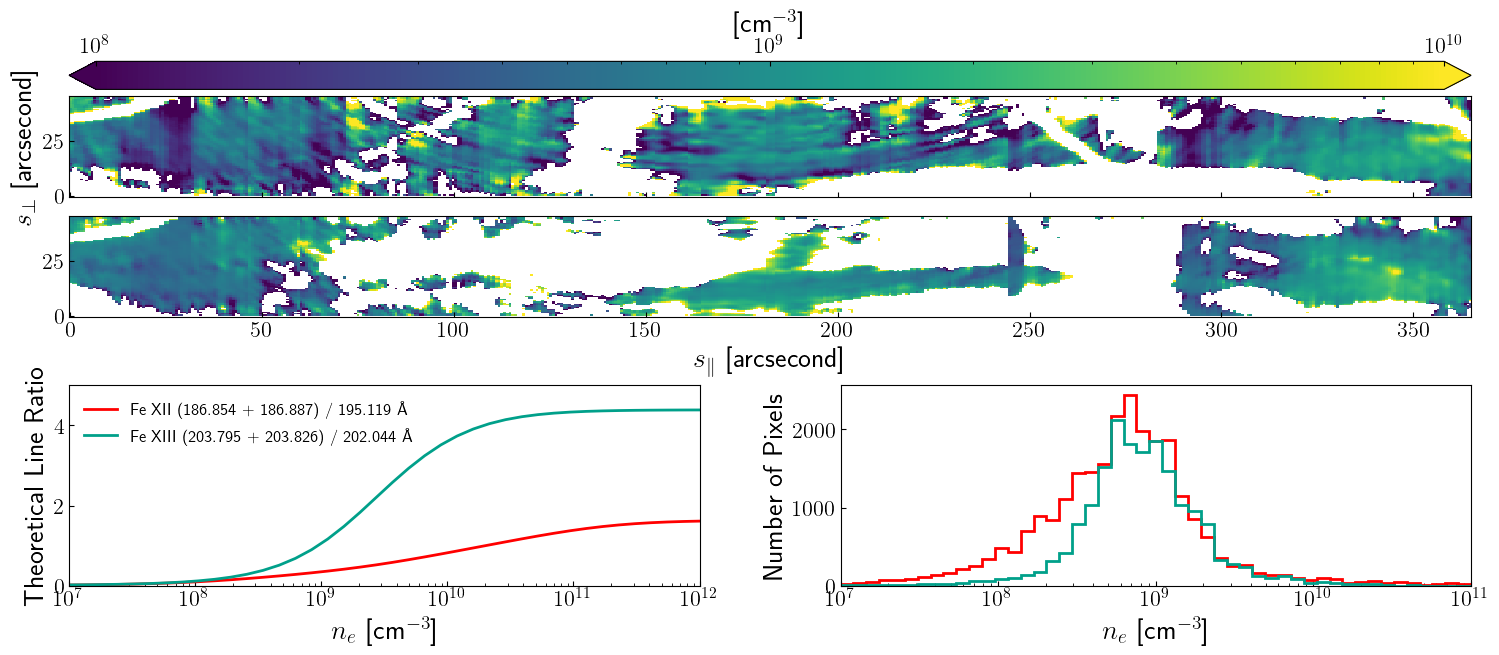

In [16]:
norm = matplotlib.colors.LogNorm(vmin=1e8, vmax=1e10,)
fig = plt.figure(figsize=np.array((1, aspect*4))*np.array(plt.rcParams['figure.figsize']), layout='constrained')
axes = fig.subplot_mosaic(
    """
    AA
    BB
    CD
    """,
    height_ratios=[1,1,2],
)
plot_kws = {'norm': norm, 'cmap': 'viridis', 'add_colorbar': False, 'x': 's_parallel', 'y': 's_perp'}
observed_density['Fe XII'].plot.imshow(ax=axes['A'],**plot_kws)
axes['A'].set_ylabel(r'$s_\perp$ [arcsecond]')
axes['A'].label_outer()
im = observed_density['Fe XIII'].plot.imshow(ax=axes['B'], **plot_kws)
axes['B'].set_xlabel(r'$s_\parallel$ [arcsecond]')
axes['B'].set_ylabel('')
#axes['B'].label_outer()

axes['C'].plot(density_for_diagnostic, intensity_ratio_fe12,
               color=list(darjeeling)[0]['color'],
               label='Fe XII (186.854 + 186.887) / 195.119 Å')
axes['C'].plot(density_for_diagnostic, intensity_ratio_fe13,
               color=list(darjeeling)[1]['color'],
               label='Fe XIII (203.795 + 203.826) / 202.044 Å')
axes['C'].set_xscale('log')
axes['C'].set_xlim(1e7,1e12)
axes['C'].set_ylim(0,5)
axes['C'].set_ylabel('Theoretical Line Ratio')
axes['C'].set_xlabel('$n_e$ [cm$^{-3}$]')
axes['C'].legend(loc=2, fontsize=0.75*plt.rcParams['legend.fontsize'])

density_bins = np.logspace(7,11,50)
observed_density['Fe XII'].plot.hist(ax=axes['D'], histtype='step', bins=density_bins, color=list(darjeeling)[0]['color']);
observed_density['Fe XIII'].plot.hist(ax=axes['D'], histtype='step', bins=density_bins, color=list(darjeeling)[1]['color']);
axes['D'].set_xscale('log')
axes['D'].set_xlim(1e7,1e11);
axes['D'].set_xlabel('$n_e$ [cm$^{-3}$]')
axes['D'].set_ylabel('Number of Pixels')

fig.colorbar(im, ax=[axes['A'],axes['B']],
             location='top',
             orientation='horizontal',
             pad=0.03,
             fraction=1,
             extend='both',
             aspect=50,
             ticks=[1e8,1e9,1e10],
             extendfrac=0.02,
             label=r'[cm$^{-3}$]',
             format=matplotlib.ticker.LogFormatterMathtext(base=10.0,))
fig.savefig(figure_directory / 'density_diagnostics.pgf',)

## Temperature Diagnostic from Filter Ratio

In [17]:
aia_temperature_map = xarray.open_dataarray(data_root / 'diagnostics' / 'filter_ratio_temperature.nc') / 1e6
aia_temperature_map.attrs['unit'] = 'MK'
aia_temperature_map = aia_temperature_map.assign_coords(time=aia_temperature_map.time/3600)

In [18]:
list(ac3)

[{'color': '#FBA72A'},
 {'color': '#D3D4D8'},
 {'color': '#CB7A5C'},
 {'color': '#5785C1'}]

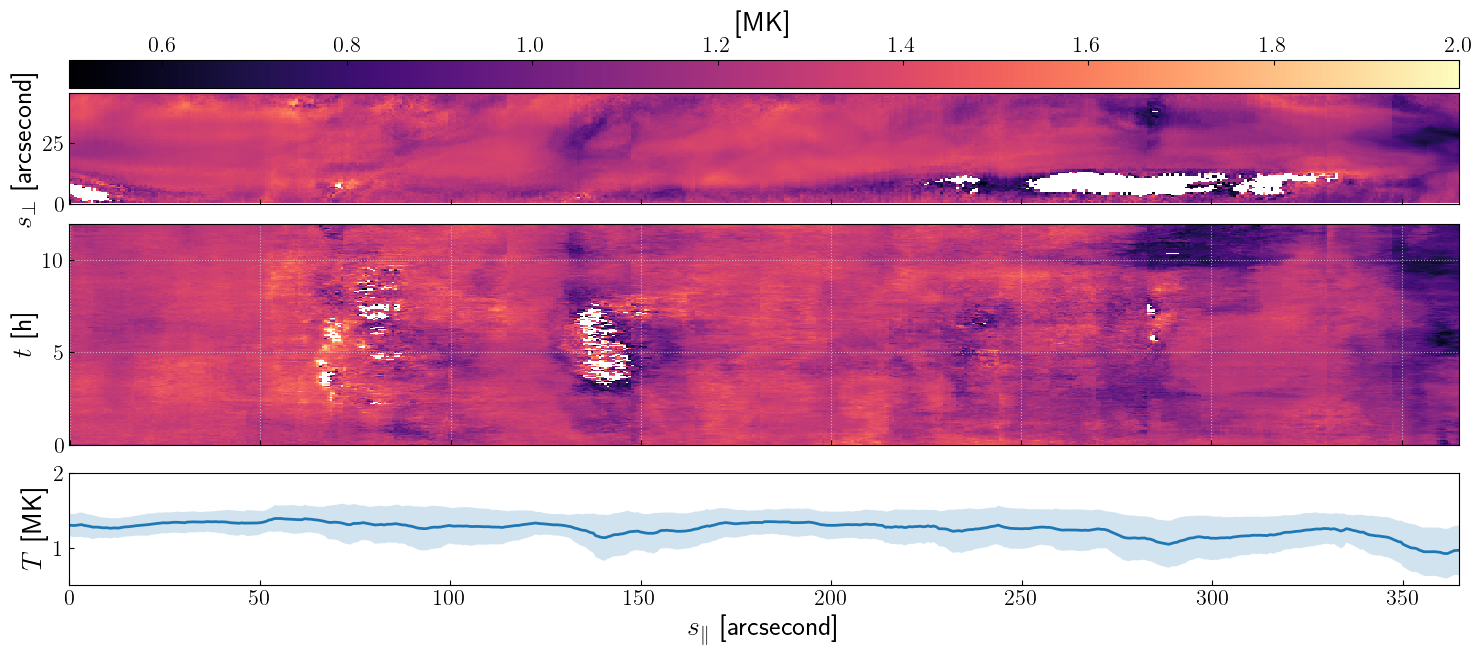

In [23]:
norm = ImageNormalize(vmin=0.5, vmax=2)
time_aspect_ratio = aia_temperature_map.shape[0] / aia_temperature_map.shape[1]
profile_aspect = (0.7-time_aspect_ratio-aspect)
fig = plt.figure(
    figsize=np.array(plt.rcParams['figure.figsize'])*np.array((1, aspect+profile_aspect+time_aspect_ratio)),
    layout='constrained'
)
axes = fig.subplot_mosaic(
    """
    A
    B
    C
    """,
    height_ratios=[1, time_aspect_ratio/aspect, profile_aspect/aspect],
)
plot_kws = {'cmap':'magma', 'add_colorbar':False, 'norm':norm, 'x': 's_parallel'}
im = aia_temperature_map.mean(dim='time', skipna=True).plot.imshow(ax=axes['A'], **plot_kws, y='s_perp')
axes['A'].label_outer()
axes['A'].set_ylabel(r'$s_\perp$ [arcsecond]')
aia_temperature_map.mean(dim='s_perp',skipna=True).plot.imshow(ax=axes['B'], **plot_kws, y='time')
axes['B'].label_outer()
axes['B'].set_ylabel(r'$t$ [h]')
axes['B'].grid(color=list(ac3)[1]['color'], alpha=0.75, ls=':')

temp_mean = aia_temperature_map.mean(dim=['time','s_perp'], skipna=True)
temp_std = aia_temperature_map.std(dim=['time','s_perp'],skipna=True)
axes['C'].plot(temp_mean.s_parallel,temp_mean, )
axes['C'].fill_between(temp_mean.s_parallel, y1=temp_mean-temp_std, y2=temp_mean+temp_std, alpha=0.2)
axes['C'].set_ylim(0.5,2)
axes['C'].set_xlim(temp_mean.s_parallel[[0,-1]])
axes['C'].set_ylabel(r'$T$ [MK]')
axes['C'].set_xlabel(r'$s_\parallel$ [arcsecond]')

fig.colorbar(im, ax=axes['A'],
             location='top',
             orientation='horizontal',
             #pad=0.005,
             fraction=1,
             label='[MK]',
             aspect=50)
fig.savefig(figure_directory / 'temperature_diagnostics.pgf',)

## DEM Analysis

Select the EIS lines appropriate for DEM analysis

In [24]:
selected_keys = [
    #'Al IX 284.015_intensity',
    #'Ar XI 188.806_intensity',
    #'Ar XIV 187.964_intensity',
    #'Ar XIV 194.396_intensity',
    #'Ca XIV 193.874_intensity',
    #'Ca XV 200.972_intensity',
    'Ca XVII 192.858_intensity',
    'Fe VIII 185.213_intensity',
    'Fe VIII 186.601_intensity',
    #'Fe IX 188.497_intensity',
    #'Fe IX 197.862_intensity',
    'Fe X 184.536_intensity',
    'Fe X 193.715_intensity',
    'Fe XI 180.401_intensity',
    'Fe XI 188.216_intensity',
    'Fe XI 188.299_intensity',
    'Fe XI 192.813_intensity',
    'Fe XII 186.880_intensity',
    'Fe XII 192.394_intensity',
    'Fe XII 195.119_intensity',
    #'Fe XII 195.179_intensity',
    #'Fe XII 203.720_intensity',
    #'Fe XIII 201.121_intensity',
    'Fe XIII 202.044_intensity',
    'Fe XIII 203.826_intensity',
    'Fe XIV 264.787_intensity',
    'Fe XIV 270.519_intensity',
    'Fe XV 284.160_intensity',
    #'Fe XVI 262.984_intensity',
    #'Fe XXIV 192.040_intensity',
    'Mg VI 270.394_intensity',
    #'Mn X 194.327_intensity',
    #'O V 192.906_intensity',
    #'S XI 188.675_intensity',
    #'S XIII 256.686_intensity',
    #'Si VII 275.368_intensity',
    #'Si VII 275.665_intensity',
    'Si X 258.375_intensity',
]

Organize intensities and responses into tables, selecting the intensity from the location where the Fe XII emission is maximized

In [25]:
i_max = np.argmax(eis_loop['Fe XII 195.119_intensity'].mean(dim='s_parallel', skipna=True).data)

NameError: name 'aia_ds' is not defined

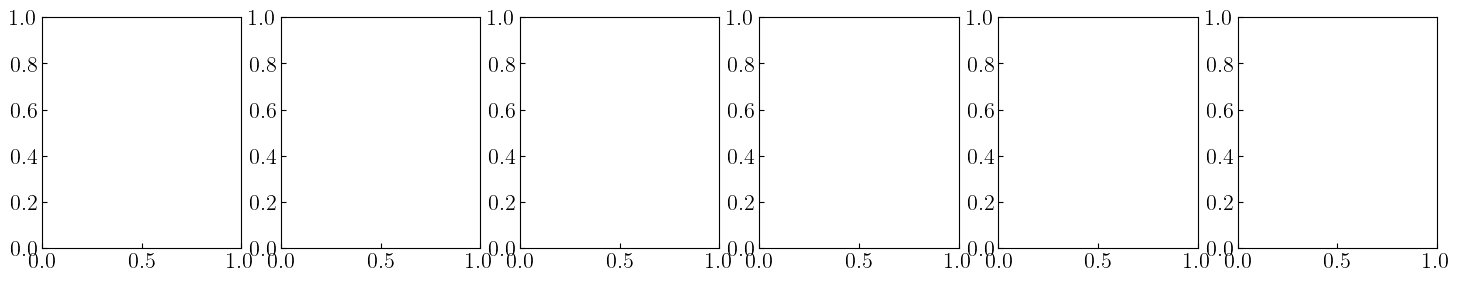

In [22]:
fig,axes = plt.subplots(1,6,figsize=(18,3),sharex=True,)
for k,ax in zip(aia_ds.keys(), axes.flatten()):
    mean_intensity = aia_ds[k].mean(dim=['time', 's_parallel'], skipna=True)
    #mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.plot(mean_intensity.s_perp[i_max], mean_intensity.data[i_max], marker='o', ls='')
    ax.axvline(x=mean_intensity.s_perp[i_max], ls='--', color='C1')

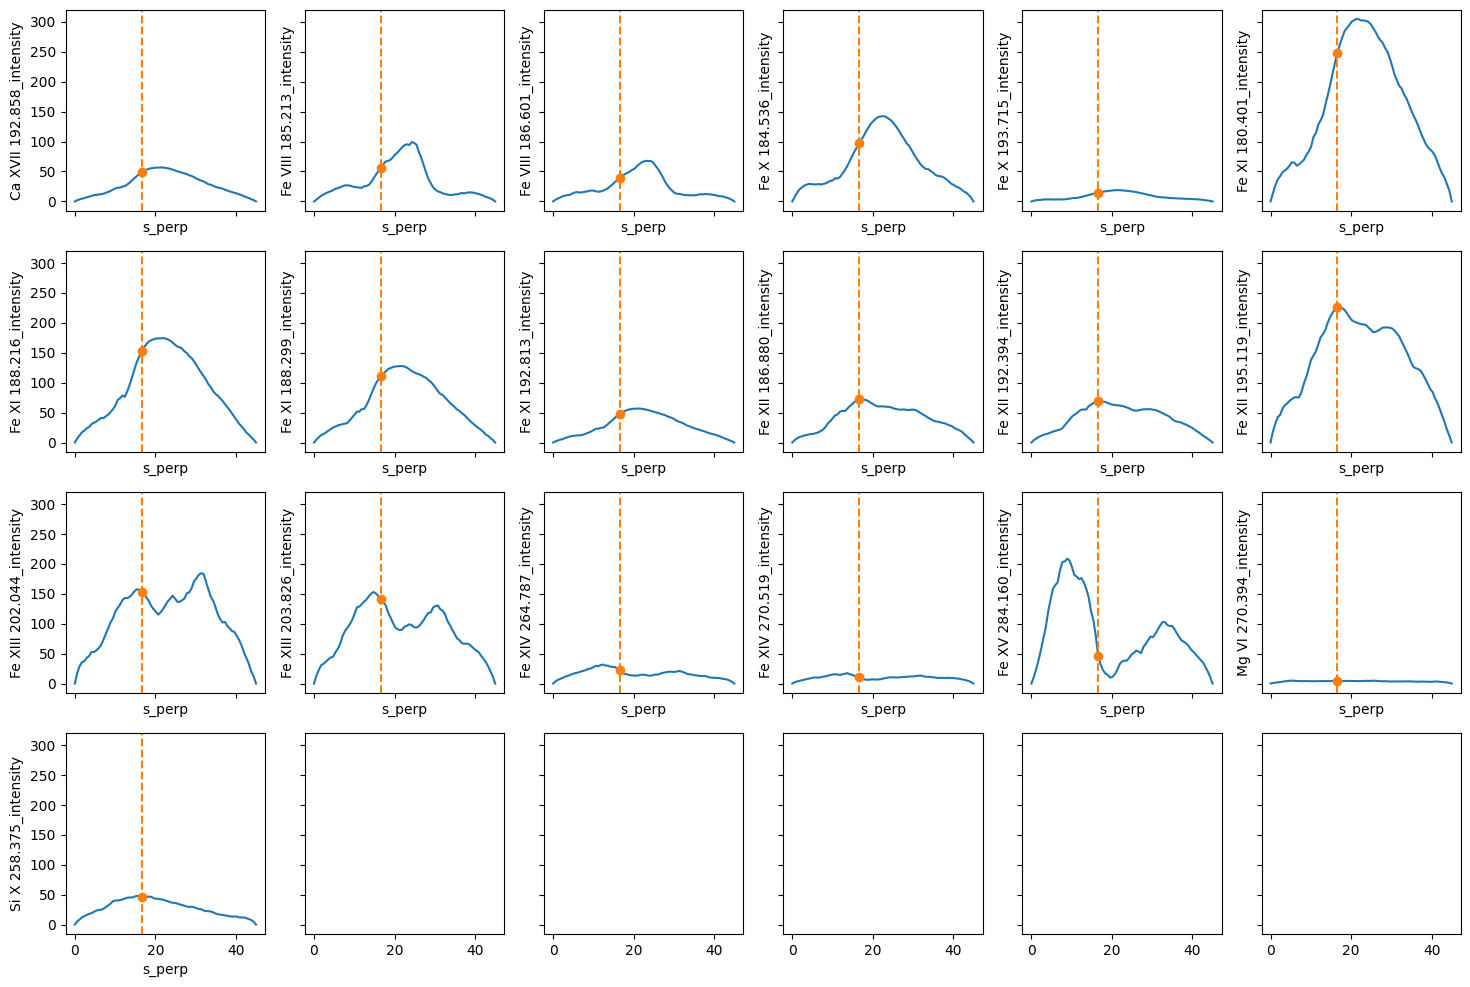

In [13]:
fig,axes = plt.subplots(4,6,figsize=(18,12),sharex=True, sharey=True)
for k,ax in zip(selected_keys, axes.flatten()):
    mean_intensity = eis_ds[k].mean(dim='s_parallel', skipna=True)
    #mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.plot(mean_intensity.s_perp[i_max], mean_intensity.data[i_max], marker='o', ls='')
    ax.axvline(x=mean_intensity.s_perp[i_max], ls='--', color='C1')

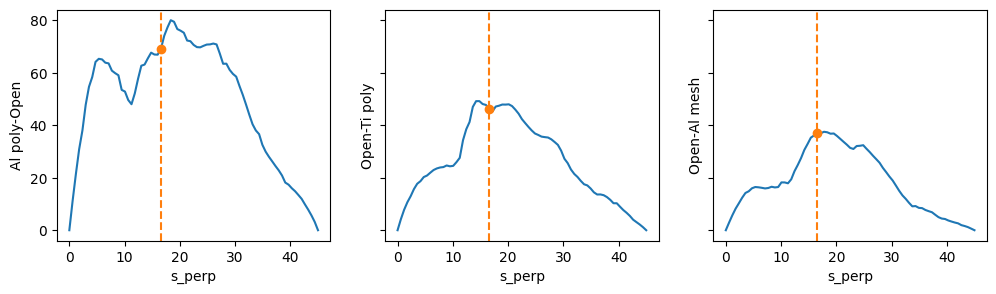

In [17]:
fig,axes = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)
for k,ax in zip(xrt_ds.keys(), axes.flatten()):
    mean_intensity = xrt_ds[k].mean(dim=['s_parallel'], skipna=True)
    #mean_intensity = mean_intensity / mean_intensity.max()
    mean_intensity.plot(ax=ax)
    ax.plot(mean_intensity.s_perp[i_max], mean_intensity.data[i_max], marker='o', ls='')
    ax.axvline(x=mean_intensity.s_perp[i_max], ls='--', color='C1')

In [26]:
lines = [k.split('_')[0].split() for k in selected_keys]
ions = [' '.join(l[:2]) for l in lines]
transitions = u.Quantity([float(l[2]) for l in lines], 'Angstrom')
line_table = astropy.table.QTable({'Ion': ions, 'Transition': transitions})
line_table['Element'] = list(map(lambda x: x.split()[0], line_table['Ion']))

In [27]:
delta_log_T = 0.02
temperature = 10**np.arange(5.3, 7.3+delta_log_T, delta_log_T)*u.K
density = 1e15*u.Unit('K cm-3') / temperature
ion_objects = {iname: fiasco.Ion(iname, temperature) for iname in np.unique(line_table['Ion'])}
goft = {k: v.contribution_function(density, couple_density_to_temperature=True) for k,v in ion_objects.items()}

In [28]:
eis_to_chianti_mapping = {
    186.880*u.Angstrom: 186.887*u.Angstrom,
}

In [29]:
goft_col = []
for row in line_table:
    waves = ion_objects[row['Ion']].transitions.wavelength[~ion_objects[row['Ion']].transitions.is_twophoton]
    eis_wavelength = eis_to_chianti_mapping.get(row['Transition'], row['Transition'])
    iwave = int(np.argmin(np.fabs(waves - eis_wavelength)))
    goft_col.append(goft[row['Ion']][..., iwave].squeeze())
goft_col = u.Quantity(goft_col)
line_table['Response'] = goft_col
line_table['Temperature'] = [temperature,]

In [30]:
element_colors = {el: color['color'] for el,color in zip(np.unique(line_table['Element']), ac2)}

In [72]:
intensity = []
intensity_error = []
for row in line_table:
    key = f'{row["Ion"]} {row["Transition"].to_value("Angstrom"):.03f}_intensity'
    _loop_slice = eis_loop[key][:, i_max]
    _loop_slice = xarray.where(np.isnan(_loop_slice), 0., _loop_slice)
    I_obs = u.Quantity(_loop_slice.mean(dim='s_parallel').data, eis_loop[key].attrs['bunit'])
    intensity.append(I_obs)
    I_obs_err = u.Quantity(eis_loop[key].std(dim='s_parallel', skipna=True).data[i_max], I_obs.unit)
    intensity_error.append(I_obs_err)
line_table['Intensity'] = u.Quantity(intensity) * 4 * np.pi * u.steradian
line_table['Intensity Error'] = 0.1*line_table['Intensity'] #u.Quantity(intensity_error) * 4 * np.pi * u.steradian

In [74]:
trf_al_poly = TemperatureResponseFundamental('Al-poly', aia_loop['171'].attrs['date-obs'])
trf_ti_poly = TemperatureResponseFundamental('Ti-poly', aia_loop['171'].attrs['date-obs'])
trf_al_mesh = TemperatureResponseFundamental('Al-mesh', aia_loop['171'].attrs['date-obs'])

In [75]:
xrt_table = astropy.table.QTable({'Filter':[], 'Intensity': [], 'Intensity Error': []}, dtype=[str, float, float])
xrt_table['Intensity'].unit = 'ct pix-1 s-1'
xrt_table['Intensity Error'].unit = 'ct pix-1 s-1'
response_row = []
for k, trf in [('Al poly-Open', trf_al_poly), ('Open-Ti poly', trf_ti_poly), ('Open-Al mesh', trf_al_mesh)]:
    _loop_slice = xrt_loop[k][:, i_max]
    _loop_slice = xarray.where(np.isnan(_loop_slice), 0., _loop_slice)
    xrt_table.add_row({
        'Filter': k,
        'Intensity': u.Quantity(_loop_slice.mean(dim='s_parallel').data, xrt_loop[k].attrs['bunit']) / u.pix,
        #'Intensity Error': u.Quantity(xrt_loop[k].std(dim='s_parallel', skipna=True)[i_max].data, xrt_loop[k].attrs['bunit']) / u.pix
    })
    response_row.append(2*np.interp(temperature, trf.CHIANTI_temperature, trf.temperature_response())/u.DN*u.ct)
xrt_table['Temperature'] = [temperature,]
xrt_table['Response'] = response_row
xrt_table['Intensity Error'] = 0.1 * xrt_table['Intensity']

In [76]:
aia_table = astropy.table.QTable({'Filter':[], 'Intensity': [], 'Intensity Error': []}, dtype=[str, float, float])
aia_table['Intensity'].unit = 'ct pix-1 s-1'
aia_table['Intensity Error'].unit = 'ct pix-1 s-1'
response_row = []
for k in aia_loop:
    _loop_slice = aia_loop[k][index_eis, :, i_max]
    _loop_slice = xarray.where(np.isnan(_loop_slice), 0., _loop_slice)
    intensity = u.Quantity(_loop_slice.mean(dim='s_parallel').data, aia_loop[k].attrs['bunit']) / u.pix
    aia_table.add_row({
        'Filter': k,
        'Intensity': intensity,
        #'Intensity Error': estimate_error(intensity*(2*u.s), float(k)*u.AA, n_sample=aia_loop[k].shape[1])/(2*u.s),
    })
    response_row.append(np.interp(temperature, AIA_TEMPERATURE_RESPONSE['temperature'], AIA_TEMPERATURE_RESPONSE[k]))
aia_table['Temperature'] = [temperature,]
aia_table['Response'] = response_row
aia_table['Intensity Error'] = 0.1*aia_table['Intensity']

Assemble components needed for the DEM MCMC inversion

In [77]:
emission_lines = []
for row in line_table:
    name = f"{row['Ion']}_{row['Transition']:.3f}"
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(row['Temperature'], row['Response'].to_value('erg cm3 s-1')*u.Unit('cm5 K-1'), name=name),
        intensity_obs=row['Intensity'].to_value('erg cm-2 s-1'),
        sigma_intensity_obs=row['Intensity Error'].to_value('erg cm-2 s-1'),
        name=name,
    )
    emission_lines.append(eline)
for row in astropy.table.vstack([aia_table,xrt_table]):
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(row['Temperature'], row['Response'].to_value('cm5 ct pix-1 s-1')*u.Unit('cm5 K-1'), name=row['Filter']),
        intensity_obs=row['Intensity'].to_value('ct pix-1 s-1'),
        sigma_intensity_obs=row['Intensity Error'].to_value('ct pix-1 s-1'),
        name=row['Filter'],
    )
    emission_lines.append(eline)

In [78]:
temperature_bins = TempBins(10 ** np.arange(5.6,7, 0.08) * u.K)

In [79]:
inverted_dem = predict_dem_emcee(emission_lines, temperature_bins, nwalkers=300, nsteps=7000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [01:28<00:00, 78.80it/s]


/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


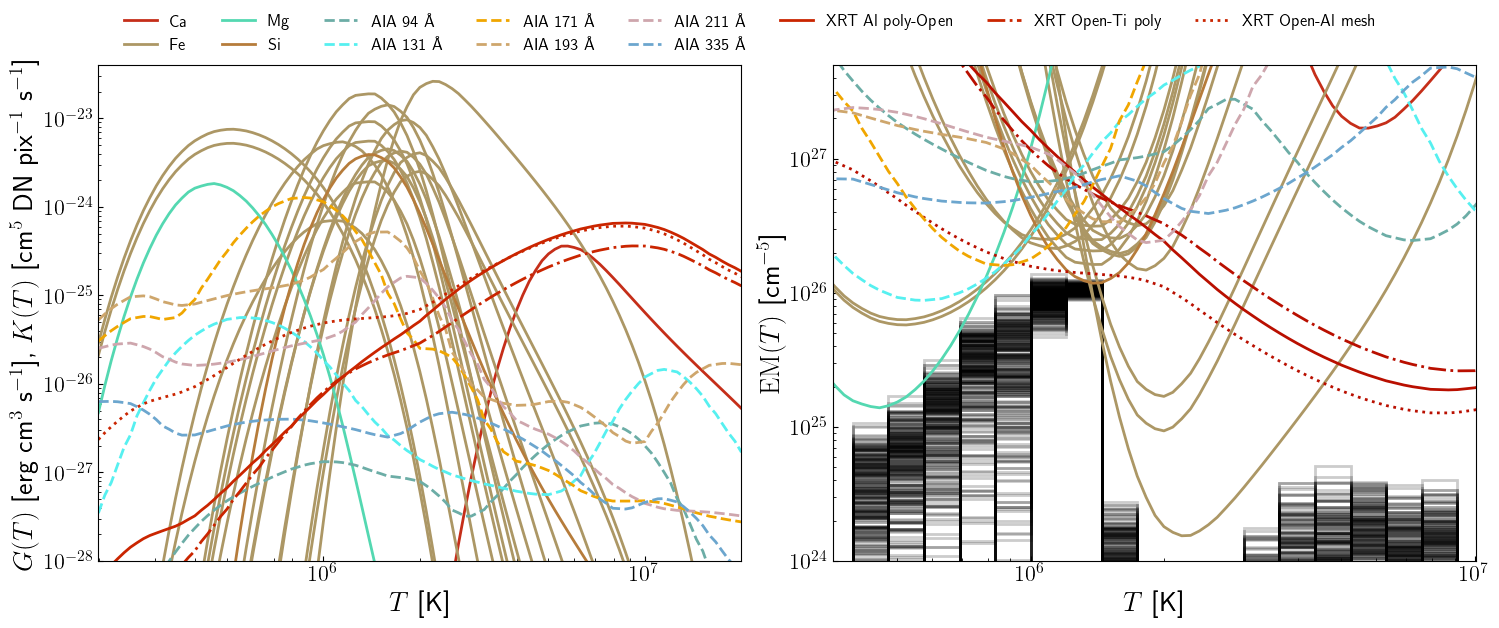

In [80]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array([1,0.675]), layout='constrained')

ax = fig.add_subplot(121)
for row in line_table:
    ax.plot(row['Temperature'], row['Response'], color=element_colors[row['Element']], label=row['Element'])
for row in aia_table:
    ax.plot(row['Temperature'], row['Response'],color=plt.get_cmap(f'sdoaia{row["Filter"]}')(0.65),
            label=f'AIA {row["Filter"]} Å', ls='--')
for row,ls in zip(xrt_table,['-', '-.', ':']):
    ax.plot(row['Temperature'], row['Response'],color=plt.get_cmap('hinodexrt')(0.55), ls=ls,
            label=f'XRT {row["Filter"]}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-28, 4e-23)
ax.set_xlim(row['Temperature'][[0,-1]].value)
ax.set_xlabel(r'$T$ [K]')
ax.set_ylabel(r'$G(T)$ [erg cm$^{3}$ s$^{-1}$], $K(T)$ [cm$^5$ DN pix$^{-1}$ s$^{-1}$]')
legend_entries = dict(zip(*ax.get_legend_handles_labels()[::-1]))

ax = fig.add_subplot(122)
with quantity_support():
    # Add inverted DEM
    for sample in inverted_dem.samples:
        ax.stairs(sample.value*u.Unit('cm-5 K-1')*temperature_bins.bin_widths, edges=temperature_bins.edges, color='k', alpha=0.2)
    # Add loci curves
    for row in line_table:
        em_loci = row['Intensity']/row['Response']
        plt.plot(row['Temperature'], em_loci, color=element_colors[row['Element']], ls='-')
    for row, ls in zip(xrt_table, ['-', '-.', ':']):
        plt.plot(row['Temperature'], row['Intensity']/row['Response'], color=plt.get_cmap('hinodexrt')(0.5), ls=ls)
    for row in aia_table:
        plt.plot(row['Temperature'], row['Intensity']/row['Response'], color=plt.get_cmap(f'sdoaia{row["Filter"]}')(0.65), ls='--')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(temperature_bins.min.to_value('K') * 0.9, temperature_bins.max * 1.1)
    ax.set_ylim(1e24*u.cm**(-5),5e27*u.cm**(-5))
    ax.set_ylabel(r'$\mathrm{EM}(T)$ [cm$^{-5}$]')
    ax.set_xlabel(r'$T$ [K]')

fig.legend(legend_entries.values(), legend_entries.keys(), loc='outside upper center', ncol=8,
           fontsize=0.75*plt.rcParams['legend.fontsize'])
fig.savefig(figure_directory / 'dem.pgf')

## Time Lag Analysis

In [39]:
timelag_maps = xarray.open_dataset(data_root / 'diagnostics' / 'time_lags.nc')

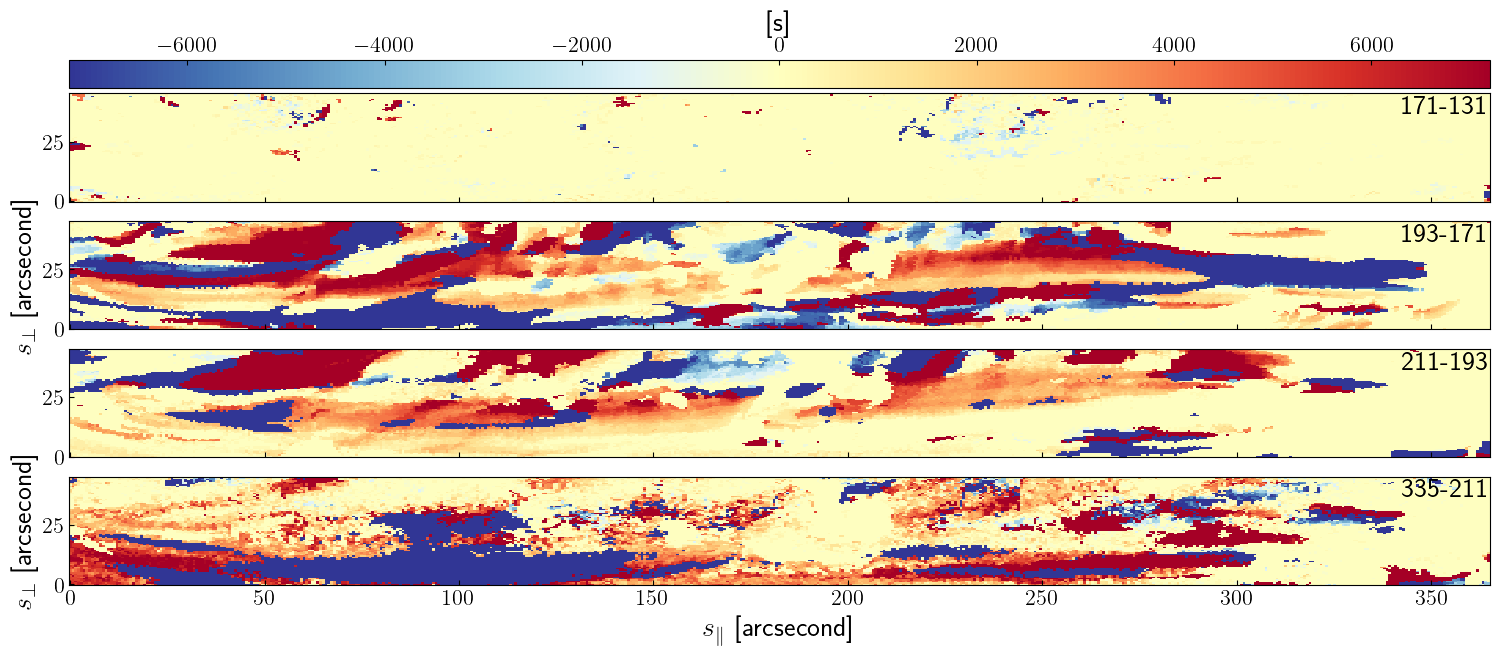

In [40]:
plot_kw = {'vmin':-7200, 'vmax':7200, 'cmap':'RdYlBu_r', 'x': 's_parallel', 'y': 's_perp', 'add_colorbar': False}
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array((1,aspect*4)), layout='constrained')
axes = fig.subplot_mosaic(
    """
    A
    B
    C
    D
    """,
    gridspec_kw={'hspace':0.0}
)
for i,(key,ax_key) in enumerate([('171_131','A'), ('193_171', 'B'), ('211_193', 'C'), ('335_211', 'D')]):
    im = timelag_maps[key].plot.imshow(ax=axes[ax_key], **plot_kw)
    axes[ax_key].set_ylabel(r'$s_\perp$ [arcsecond]' if i%2 else '')
    axes[ax_key].set_xlabel(r'$s_\parallel$ [arcsecond]')
    axes[ax_key].label_outer()
    axes[ax_key].text(timelag_maps.coords['s_parallel'][-1],
                      timelag_maps.coords['s_perp'][-1],
                      '{}-{}'.format(*key.split('_')),
                      horizontalalignment='right',
                      verticalalignment='top',
                      color='k',
                      fontsize=plt.rcParams['axes.labelsize'])
fig.colorbar(im, ax=axes['A'], orientation='horizontal', location='top', fraction=1, aspect=50,label='[s]')
fig.savefig(figure_directory / 'time_lags.pgf')

## Modeling

In [160]:
import synthesizAR
from synthesizAR.visualize import plot_fieldlines
from astropy.visualization import AsinhStretch
from pydrad.parse import Strand

### Field Lines

In [84]:
skeleton = synthesizAR.Skeleton.from_asdf('model_data/base_skeleton.asdf')

In [85]:
m_aia_171_sub = m_aia_171.submap(
    SkyCoord(Tx=m_aia_171.bottom_left_coord.Tx, Ty=0*u.arcsec, frame=m_aia_171.coordinate_frame),
    top_right=m_aia_171.top_right_coord,
)

In [127]:
s_norm = np.linspace(0,1,1000)
b_mean = np.array([interp1d(l.field_aligned_coordinate_norm.value, l.field_strength)(s_norm) for l in skeleton.loops]).mean(axis=0)
a_mean = []
for l in skeleton.loops:
    b_interp = interp1d(l.field_aligned_coordinate_norm.value, l.field_strength)(s_norm)
    a_mean.append((b_interp[0] / b_interp))
a_mean = np.array(a_mean).mean(axis=0)

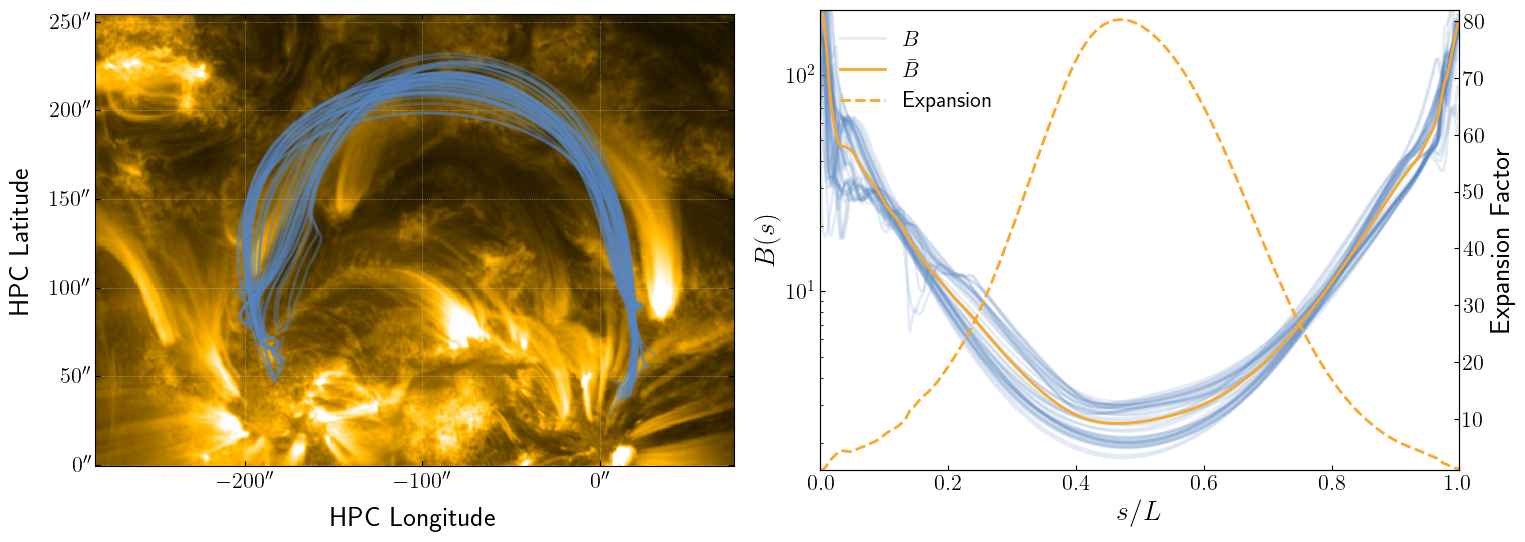

In [159]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array([1,0.5]))

ax = fig.add_subplot(121, projection=m_aia_171_sub)
m_aia_171_sub.plot(axes=ax, title=False, norm=ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch()))
for loop in skeleton.loops:
    ax.plot_coord(loop.coordinate, alpha=0.4, color=list(ac3)[-1]['color'])

ax.coords[0].set_axislabel('HPC Longitude')
ax.coords[1].set_axislabel('HPC Latitude')

ax = fig.add_subplot(122)
for l in skeleton.loops:
    l1, = ax.plot(l.field_aligned_coordinate_norm, l.field_strength,
                  alpha=0.15, color=list(ac3)[-1]['color'], label=r'$B$')
l2, = ax.plot(s_norm, b_mean, color=list(ac3)[0]['color'], label=r'$\bar{B}$')

ax2 = ax.twinx()
l3, = ax2.plot(s_norm, a_mean, color=list(ac3)[0]['color'], ls='--', label='Expansion')

ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(1.5, 2e2)
ax2.set_ylim(1,82)
ax.set_xlabel(r'$s/L$')
ax.set_ylabel(r'$B(s)$')
ax2.set_ylabel(r'Expansion Factor')

handles_1,labels_1 = ax.get_legend_handles_labels()
ax.legend([l1,l2,l3], [l1.get_label(), l2.get_label(), l3.get_label()], loc=2)

plt.subplots_adjust(wspace=0.135, left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.savefig(figure_directory / 'aia_fieldlines_b_profiles.pgf')

### Hydrodynamic Results

In [161]:
hydrad_paths = [
    pathlib.Path('model_data/hydrad_runs/run_1/'),
    pathlib.Path('model_data/hydrad_runs/run_2/'),
    pathlib.Path('model_data/hydrad_runs/run_3/'),
    pathlib.Path('model_data/hydrad_runs/run_4'),
    pathlib.Path('model_data/hydrad_runs/run_7/'),
]
hydrad_runs = [Strand(p) for p in hydrad_paths]

In [211]:
hydrad_runs[2].config['heating']

{'background': {'location': <Quantity 0. cm>,
  'rate': <Quantity 0. erg / (s cm3)>,
  'scale_height': <Quantity 1.e+300 cm>,
  'use_initial_conditions': False},
 'electron_heating': 1.0,
 'events': [{'decay_duration': <Quantity 0. s>,
   'location': <Quantity 2.45247551e+09 cm>,
   'rate': <Quantity 0.00241925 erg / (s cm3)>,
   'rise_duration': <Quantity 30. s>,
   'scale_height': <Quantity 3.53156473e+08 cm>,
   'time_start': <Quantity 0. s>,
   'total_duration': <Quantity 1.99965278 d>},
  {'decay_duration': <Quantity 0. s>,
   'location': <Quantity 3.28631718e+10 cm>,
   'rate': <Quantity 0.00241925 erg / (s cm3)>,
   'rise_duration': <Quantity 30. s>,
   'scale_height': <Quantity 3.53156473e+08 cm>,
   'time_start': <Quantity 0. s>,
   'total_duration': <Quantity 1.99965278 d>}]}

In [213]:
hydrad_runs[0].loop_length.to('Mm')

<Quantity 353.156473 Mm>

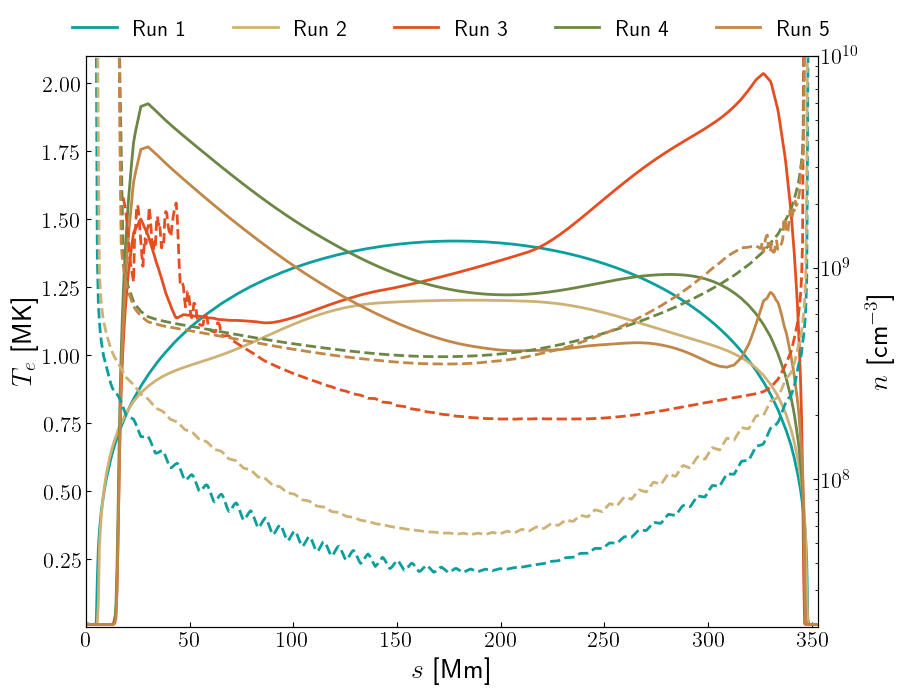

In [214]:
time_range = [36,48]*u.h

fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array([0.6,0.75]),
                 layout='constrained')
ax = fig.add_subplot()
ax2 = ax.twinx()

for i, (run, color) in enumerate(zip(hydrad_runs,ac1)):
    #label = ' '.join(run.hydrad_root.name.split('_')).capitalize()
    label = f'Run {i+1}'
    grid = run.get_uniform_grid(0.5*u.Mm)
    idx = np.where(np.logical_and(run.time>=time_range[0], run.time<=time_range[1]))
    Te_mean = run[idx].to_constant_grid('electron_temperature', grid).mean(axis=0)
    n_mean = run[idx].to_constant_grid('electron_density', grid).mean(axis=0)
    ax.plot(grid.to('Mm'), Te_mean.to('MK'), color=color['color'], label=label)
    ax2.plot(grid.to('Mm'), n_mean, color=color['color'], ls='--')

ax2.set_yscale('log')
ax.set_xlim(grid[[0, -1]].to_value('Mm'))
ax.set_ylim(1e-3,2.1)
ax2.set_ylim(2e7,1e10)

ax.set_xlabel(r'$s$ [Mm]')
ax.set_ylabel(r'$T_e$ [MK]')
ax2.set_ylabel(r'$n$ [cm$^{-3}$]')

fig.legend(loc='outside upper center', ncol=5)

fig.savefig(figure_directory / 'hydrodynamic_results.pgf')

### Forward-modeled Intensities

In [281]:
norms = {
    maps_run2[0].latex_name: ImageNormalize(vmin=0, vmax=7e2, stretch=AsinhStretch()),
    maps_run2[1].latex_name: ImageNormalize(vmin=0, vmax=7e2, stretch=AsinhStretch()),
    maps_run2[2].latex_name: ImageNormalize(vmin=0, vmax=1e3, stretch=AsinhStretch()),
    maps_run2[3].latex_name: ImageNormalize(vmin=0, vmax=1e3, stretch=LogStretch()),
}

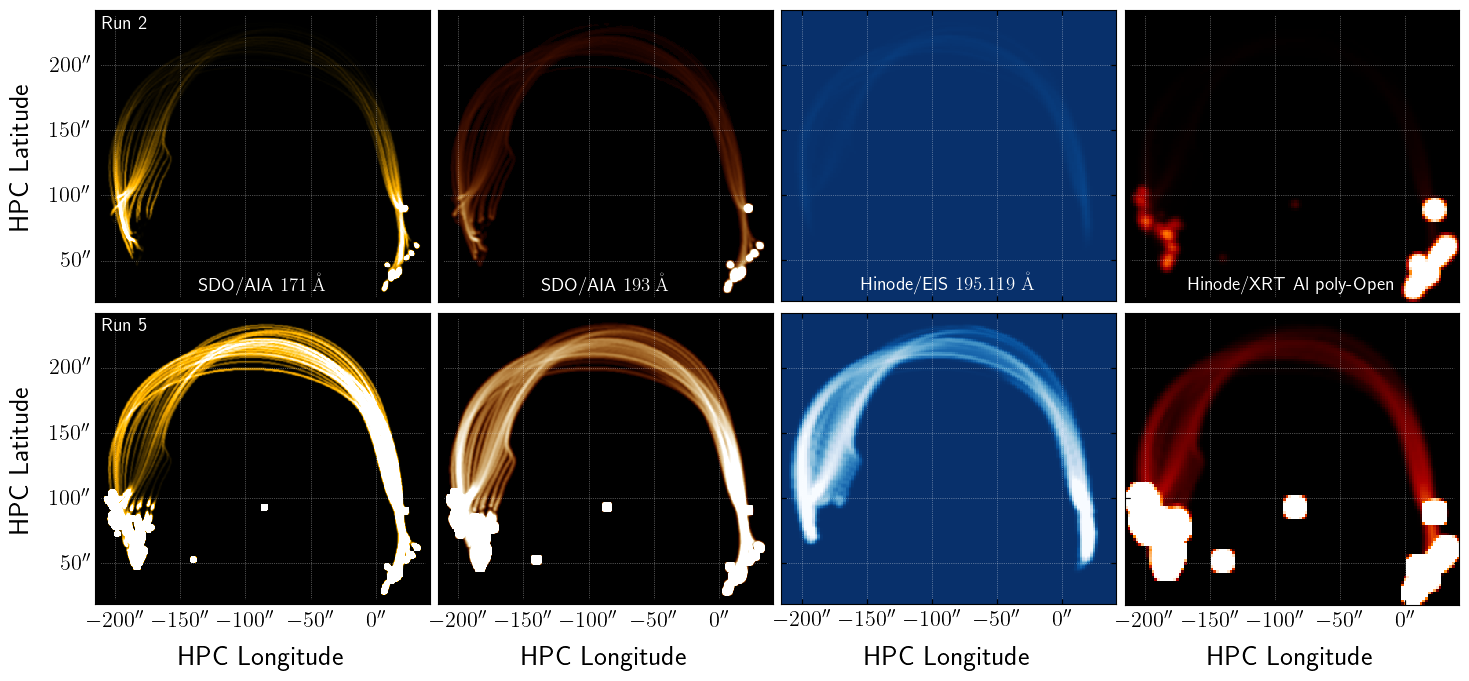

In [302]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array([1,0.65]))

# Run 2
maps_run2 = sunpy.map.Map([
    'model_data/SDO_AIA/run_2/171_t0.fits',
    'model_data/SDO_AIA/run_2/193_t0.fits',
    'model_data/Hinode_EIS/run_2/Fe_XII_195.119_t0.fits',
    'model_data/Hinode_XRT/run_2/Al_poly_Open_t0.fits',
])
maps_run5 = sunpy.map.Map([
    'model_data/SDO_AIA/run_7/171_t0.fits',
    'model_data/SDO_AIA/run_7/193_t0.fits',
    'model_data/Hinode_EIS/run_7/Fe_XII_195.119_t0.fits',
    'model_data/Hinode_XRT/run_7/Al_poly_Open_t0.fits',
])

for i,m in enumerate(maps_run2):
    ax = fig.add_subplot(2,len(maps_run2),i+1,projection=m)
    m.plot(axes=ax, title=False, annotate=False, norm=norms[m.latex_name])
    if i == 0:
        ax.coords[1].set_axislabel('HPC Latitude')
    else:
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[0].set_ticklabel_visible(False)

    filter_label = m.wavelength.to_string(format="latex_inline") if m.wavelength is not None else m.measurement
    filter_label = f'{m.observatory}/{m.detector} {filter_label}'
    ax.text(
        m.data.shape[1]//2,
        m.data.shape[0]*0.02,
        filter_label,
        fontsize=0.85*plt.rcParams['legend.fontsize'],
        color='w',
        ha='center',
        va='bottom',
    )
    if i == 0:
        ax.text(
            m.data.shape[1]*0.02,
            m.data.shape[0]*0.98,
            'Run 2',
            fontsize=0.85*plt.rcParams['legend.fontsize'],
            color='w',
            ha='left',
            va='top',
        )

# Run 5
for i,m in enumerate(maps_run5):
    ax = fig.add_subplot(2,len(maps_run2),i+1+len(maps_run2),projection=m)
    m.plot(axes=ax, title=False, annotate=False, norm=norms[m.latex_name])
    if i == 0:
        ax.coords[1].set_axislabel('HPC Latitude')
    else:
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_axislabel('HPC Longitude')
    if i == 0:
        ax.text(
            m.data.shape[1]*0.02,
            m.data.shape[0]*0.98,
            'Run 5',
            fontsize=0.85*plt.rcParams['legend.fontsize'],
            color='w',
            ha='left',
            va='top',
        )

plt.subplots_adjust(wspace=0.025,hspace=0.025,left=0.04167, right=1-0.04167, bottom=0, top=1)

fig.savefig(figure_directory / 'synthetic_emission.pgf')

### Diagnostics

Density diagnostic, filter ratio

In [305]:
fe12_maps = sunpy.map.Map('model_data/Hinode_EIS/run_4/Fe_XII_*_t0.fits')

TypeError: '<' not supported between instances of 'EISMap' and 'EISMap'

In [311]:
fe12_ratio = (fe12_maps[0] + fe12_maps[1].quantity) / fe12_maps[2].quantity

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


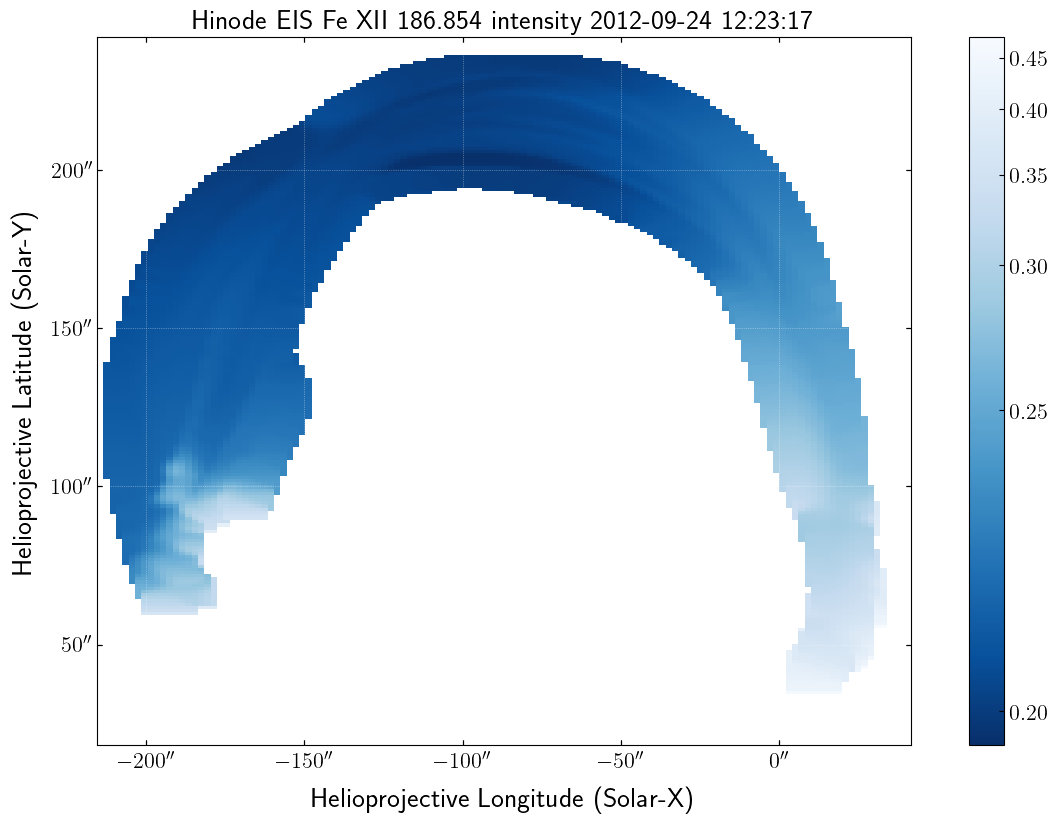

In [312]:
fe12_ratio.peek()

In [398]:
def map_ratio_to_quantity_sunpy(observed_ratio, quantity, theoretical_ratio):
    """
    For a given intensity ratio curve and two associated intensity maps, calculate the resulting
    density map.
    """
    f_ratio_to_quantity = interp1d(theoretical_ratio.decompose().value,
                                   quantity.value,
                                   bounds_error=False,
                                   fill_value=np.nan)
    observed_quantity = f_ratio_to_quantity(observed_ratio.data)
    observed_quantity = sunpy.map.GenericMap(observed_quantity, observed_ratio.meta,
                                             mask=np.isnan(observed_ratio.data))
    observed_quantity.meta['bunit'] = quantity.unit.to_string()
    return observed_quantity

In [399]:
def temperature_diagnostic_sunpy(map_a, map_b, channel_a, channel_b, T_lower = 0.5*u.MK, T_upper = 2*u.MK):
    denom = np.where(map_b.data==0, np.nan, map_b.data)
    intensity_ratio = map_a / denom
    
    T_indices = np.where(np.logical_and(AIA_TEMPERATURE_RESPONSE['temperature'] >= T_lower,
                                        AIA_TEMPERATURE_RESPONSE['temperature'] <= T_upper))
    filter_ratio = AIA_TEMPERATURE_RESPONSE[channel_a] / AIA_TEMPERATURE_RESPONSE[channel_b]
    filter_temperature = AIA_TEMPERATURE_RESPONSE['temperature']
    return map_ratio_to_quantity_sunpy(intensity_ratio,
                                       filter_temperature[T_indices],
                                       filter_ratio[T_indices])

/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/hinode-2023-loops-poster/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


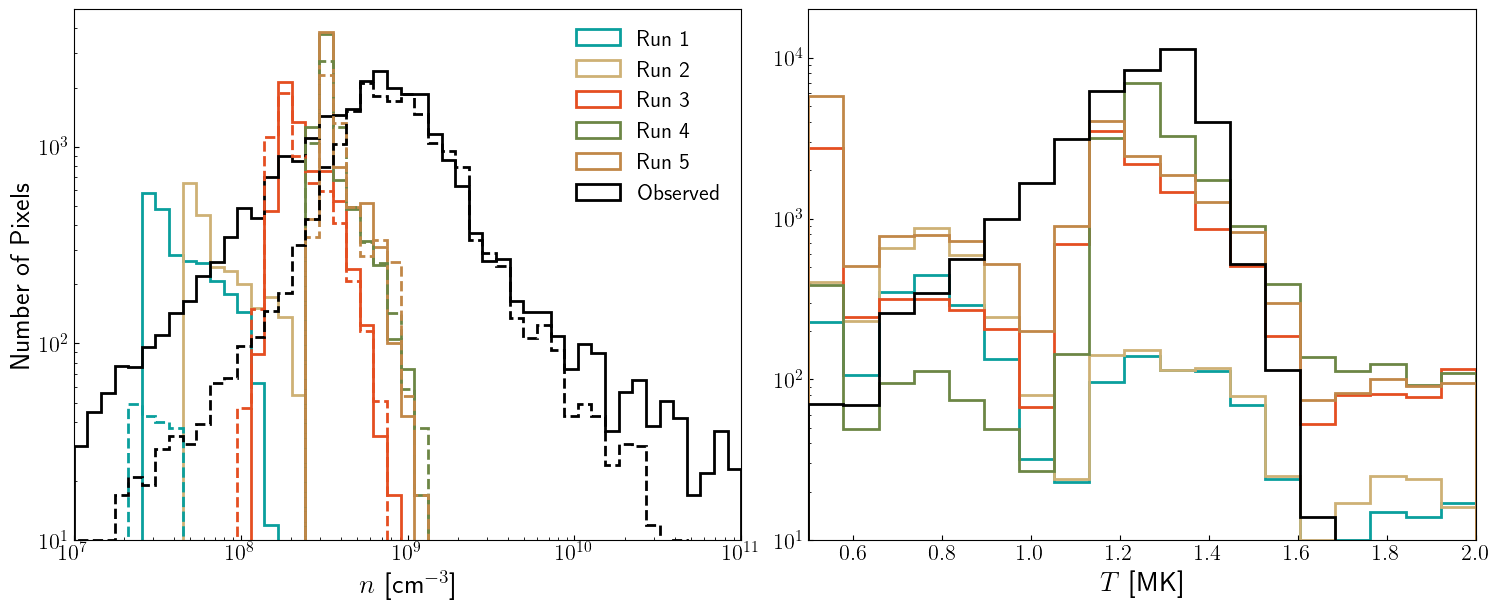

In [419]:
fig = plt.figure(figsize=np.array(plt.rcParams['figure.figsize'])*np.array([1,0.65]),
                 layout='constrained')

ax = fig.add_subplot(121)

for i, color in zip([1,2,3,4,7],ac1):
    fe12_maps = sunpy.map.Map(f'model_data/Hinode_EIS/run_{i}/Fe_XII_*_t0.fits')
    fe12_ratio = (fe12_maps[0] + fe12_maps[1].quantity) / fe12_maps[2].quantity
    fe12_density_map = map_ratio_to_quantity_sunpy(fe12_ratio, density_for_diagnostic, intensity_ratio_fe12)
    total_mask = np.logical_or(fe12_maps[2].data<5, fe12_density_map.mask)
    ax.hist(fe12_density_map.data[~total_mask],
            bins=density_bins,
            histtype='step',
            color=color['color'],
            log=True,
            label=f'Run {5 if i==7 else i}')

observed_density['Fe XII'].plot.hist(ax=ax, histtype='step', bins=density_bins, color='k', label='Observed');

for i, color in zip([1,2,3,4,7],ac1):
    fe13_maps = sunpy.map.Map(f'model_data/Hinode_EIS/run_{i}/Fe_XIII_*_t0.fits')
    fe13_ratio = (fe13_maps[1] + fe13_maps[2].quantity) / fe13_maps[0].quantity
    fe13_density_map = map_ratio_to_quantity_sunpy(fe13_ratio, density_for_diagnostic, intensity_ratio_fe13)
    total_mask = np.logical_or(fe13_maps[0].data<5, fe13_density_map.mask)
    ax.hist(fe13_density_map.data[~total_mask],
            bins=density_bins,
            histtype='step',
            ls='--',
            color=color['color'],
            log=True)

observed_density['Fe XIII'].plot.hist(ax=ax, histtype='step', bins=density_bins, color='k', ls='--');

ax.set_xscale('log')
ax.set_ylim(10, 5e3)
ax.set_xlim(1e7, 1e11)
ax.set_xlabel(r'$n$ [cm$^{-3}$]')
ax.set_ylabel('Number of Pixels')
ax.legend()

ax = fig.add_subplot(122)

temperature_map_bins = np.linspace(0.5,2,20)
for i, color in zip([1,2,3,4,7], ac1):
    _m_193 = sunpy.map.Map(f'model_data/SDO_AIA/run_{i}/193_t0.fits')
    _m_171 = sunpy.map.Map(f'model_data/SDO_AIA/run_{i}/171_t0.fits')
    temp_map = temperature_diagnostic_sunpy(_m_193, _m_171, '193', '171',)
    total_mask = np.logical_or(_m_171.data<=100, temp_map.mask)
    ax.hist(temp_map.quantity[~total_mask].to_value('MK'),
            bins=temperature_map_bins,
            histtype='step',
            ls='-',
            color=color['color'],
            log=True)

aia_temperature_map.mean(dim='time', skipna=True).plot.hist(ax=ax, log=True, color='k', histtype='step',
                                                            bins=temperature_map_bins)

ax.set_ylim(10, 2e4)
ax.set_xlim(0.5, 2)
ax.set_xlabel(r'$T$ [MK]')

fig.savefig(figure_directory / 'synthetic_temperature_density_diagnostics.pgf')

In [394]:
temp_map.unit

Unit("ct / (pix s)")

In [390]:
len(_m_193)

1

## Tables

In [402]:
import astropy.table
import io
import astropy.io

In [407]:
caption = r"Model heating scenarios. The second column, $s_H$, is the heating scale height. The third and fourth columns are the nominal heating rates in the left ($s=0$) and right ($s=L$) legs of the loop, respectively. The last column denotes whether area expansion is included or not.\label{tab:heating-scenarios}"
tab = astropy.table.Table(
    data = {
        'Run': [
            1,
            2,
            3,
            4,
            5,
        ],
        r'$s_H$': [
            np.inf,
            np.inf,
            3.319722032175333,
            3.319722032175333,
            3.319722032175333,
        ],
        r'$E_{0,L}$': [
            8.70559148699749e-06,
            8.70559148699749e-06,
            2e-3,
            0,
            0,
        ],
        r'$E_{0,R}$': [
            8.70559148699749e-06,
            8.70559148699749e-06,
            2e-3,
            4e-3,
            4e-3,
        ],
        'Expansion?': [
            'No',
            'Yes',
            'Yes',
            'No',
            'Yes',
        ],
    }
)
units = {
    r'$s_H$': 'Mm',
    r'$E_{0,L}$': r'erg cm$^{-3}$ s$^{-1}$',
    r'$E_{0,R}$': r'erg cm$^{-3}$ s$^{-1}$',
}
formats = {
    r'$s_H$': lambda x: r'$\infty$' if x==np.inf else f'{x:.2f}',
    r'$E_{0,L}$': '%.2g',
    r'$E_{0,R}$': '%.2g',
}
with io.StringIO() as f:
    astropy.io.ascii.write(tab,
                format='latex',
                latexdict={'units': units}, 
                formats=formats,
                caption=caption, 
                output=f)
    tab_str = f.getvalue()

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_19973/2930002295.py:47: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  r'$s_H$': lambda x: r'$\infty$' if x==np.inf else f'{x:.2f}',


In [408]:
print(tab_str)

\begin{table}
\caption{Model heating scenarios. The second column, $s_H$, is the heating scale height. The third and fourth columns are the nominal heating rates in the left ($s=0$) and right ($s=L$) legs of the loop, respectively. The last column denotes whether area expansion is included or not.\label{tab:heating-scenarios}}
\begin{tabular}{ccccc}
Run & $s_H$ & $E_{0,L}$ & $E_{0,R}$ & Expansion? \\
 & Mm & erg cm$^{-3}$ s$^{-1}$ & erg cm$^{-3}$ s$^{-1}$ &  \\
1 & $\infty$ & 8.7e-06 & 8.7e-06 & No \\
2 & $\infty$ & 8.7e-06 & 8.7e-06 & Yes \\
3 & 3.32 & 0.002 & 0.002 & Yes \\
4 & 3.32 & 0 & 0.004 & No \\
5 & 3.32 & 0 & 0.004 & Yes \\
\end{tabular}
\end{table}

